# Install and import libraries

In [ ]:
!pip install timm
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd

import optuna
from optuna.trial import TrialState

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.utils.class_weight import compute_class_weight

import imblearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Loading in the Plant Pathology 2021 - FGVC8 data set:


In [ ]:
# Install Kaggle
!pip install -q kaggle

In [ ]:
# Upload kaggle key:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hugomerkens","key":"b88ed1c0ea66e3cf84a3a1b1d040750f"}'}

In [ ]:
# Create a Kaggle folder
! mkdir ~/.kaggle

In [ ]:
# Copy the kaggle.json file to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [08:37<00:00, 38.4MB/s]
100% 14.9G/14.9G [08:37<00:00, 30.9MB/s]


In [ ]:
!unzip plant-pathology-2021-fgvc8.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: train_images/e00c97b2de4749ce.jpg  
  inflating: train_images/e00df890cfe62736.jpg  
  inflating: train_images/e00ed0bf43a87f25.jpg  
  inflating: train_images/e00f759d65d52887.jpg  
  inflating: train_images/e00f934d9e50ad5b.jpg  
  inflating: train_images/e00fce341cb63da5.jpg  
  inflating: train_images/e010c7c35ecf3d1c.jpg  
  inflating: train_images/e01112939f783fec.jpg  
  inflating: train_images/e01592da4d71b8be.jpg  
  inflating: train_images/e0189acaf8cf80fd.jpg  
  inflating: train_images/e0189e4999bdd0fa.jpg  
  inflating: train_images/e01ae16d4a759cb5.jpg  
  inflating: train_images/e01dc39ccb2b4ccb.jpg  
  inflating: train_images/e01e42d90c66f3f3.jpg  
  inflating: train_images/e01e870bec65f40f.jpg  
  inflating: train_images/e01f17e0187fb80f.jpg  
  inflating: train_images/e01f503cb752e6c5.jpg  
  inflating: train_images/e024b69a784e9fc3.jpg  
  inflating: train_images/e026b4c23c9fcfc4.jpg  
  inflating: tr

In [ ]:
image_dir= '../content/train_images'
print(f"There are {len(os.listdir(image_dir))} images in the training set.")

image_labels = pd.read_csv('../content/train.csv')
print(f"There are {len(image_labels)} labels for the training set.")

There are 18632 images in the training set.
There are 18632 labels for the training set.


# Split the data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import os
import shutil

In [ ]:
image_labels.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [ ]:
# Split the data into training, validation, and testing sets
train_df, test_df = train_test_split(image_labels, test_size=0.2, random_state=42, stratify=image_labels['labels'])

print(f'The training data contains {len(train_df)} images and it is {np.round((len(train_df)/ len(image_labels))*100, 2)}% of the dataset')
print(f'The validation data contains {len(test_df)} images and it is {np.round((len(test_df)/ len(image_labels))*100, 2)}% of the dataset')

The training data contains 14905 images and it is 80.0% of the dataset
The validation data contains 3727 images and it is 20.0% of the dataset


In [ ]:
import os
import shutil

# Assuming you have a list of labels in 'train_labels' DataFrame
labels = image_labels['labels'].unique()

# Create directories for train, validation, and test sets
# Define the directories for the images
train_dir = '../content/train_images'
test_dir = '../content/test_images'


# Create label directories within train and test
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

In [ ]:
# Check if all directories are created correctly
print("Train Directories:")
for label in labels:
    print(os.path.join(train_dir, label))

print("\nTest Directories:")
for label in labels:
    print(os.path.join(test_dir, label))

Train Directories:
../content/train_images/healthy
../content/train_images/scab frog_eye_leaf_spot complex
../content/train_images/scab
../content/train_images/complex
../content/train_images/rust
../content/train_images/frog_eye_leaf_spot
../content/train_images/powdery_mildew
../content/train_images/scab frog_eye_leaf_spot
../content/train_images/frog_eye_leaf_spot complex
../content/train_images/rust frog_eye_leaf_spot
../content/train_images/powdery_mildew complex
../content/train_images/rust complex

Test Directories:
../content/test_images/healthy
../content/test_images/scab frog_eye_leaf_spot complex
../content/test_images/scab
../content/test_images/complex
../content/test_images/rust
../content/test_images/frog_eye_leaf_spot
../content/test_images/powdery_mildew
../content/test_images/scab frog_eye_leaf_spot
../content/test_images/frog_eye_leaf_spot complex
../content/test_images/rust frog_eye_leaf_spot
../content/test_images/powdery_mildew complex
../content/test_images/rust 

In [ ]:
# Copy images to the respective directories
for image_name, label in zip(train_df['image'], train_df['labels']):
    source_path = os.path.join(image_dir, image_name)
    destination_path = os.path.join(train_dir, label, image_name)
    shutil.copy(source_path, destination_path)

for image_name, label in zip(test_df['image'], test_df['labels']):
    source_path = os.path.join(image_dir, image_name)
    destination_path = os.path.join(test_dir, label, image_name)
    shutil.copy(source_path, destination_path)

In [ ]:
import os

# Define the directories for the images
train_dir = '../content/train_images'
test_dir = '../content/test_images'

# Function to count the number of files in a directory
def count_files(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Count the number of images in each directory
train_image_count = sum(count_files(os.path.join(train_dir, label)) for label in labels)
test_image_count = sum(count_files(os.path.join(test_dir, label)) for label in labels)

# Print the results
print(f'The training directory contains {train_image_count} images')
print(f'The test directory contains {test_image_count} images')

The training directory contains 14905 images
The test directory contains 3727 images


# Create insights in the data



## Show class distribution

In [ ]:
print(image_labels['labels'].value_counts())
print()

print(f"There are {len(image_labels['labels'].value_counts())} classes")

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

There are 12 classes


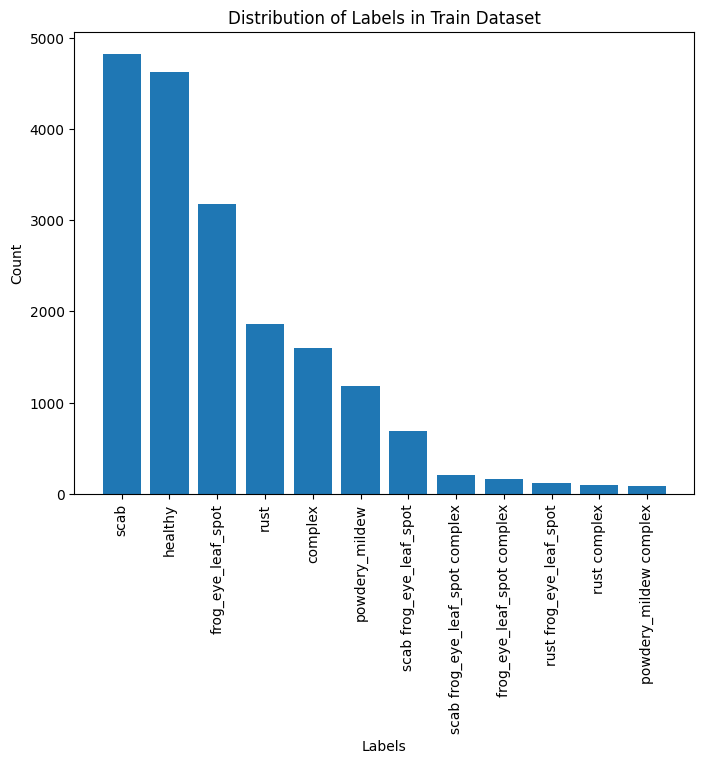

In [ ]:
import matplotlib.pyplot as plt

# Get the value counts of the 'labels' column
value_counts = image_labels['labels'].value_counts()

# Create a bar plot of the value counts
plt.figure(figsize=(8,6))
plt.bar(value_counts.index, value_counts.values)

# Set the title, x-axis label, and y-axis label
plt.title('Distribution of Labels in Train Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')

# Rotate the x-axis tick labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

## See some samples

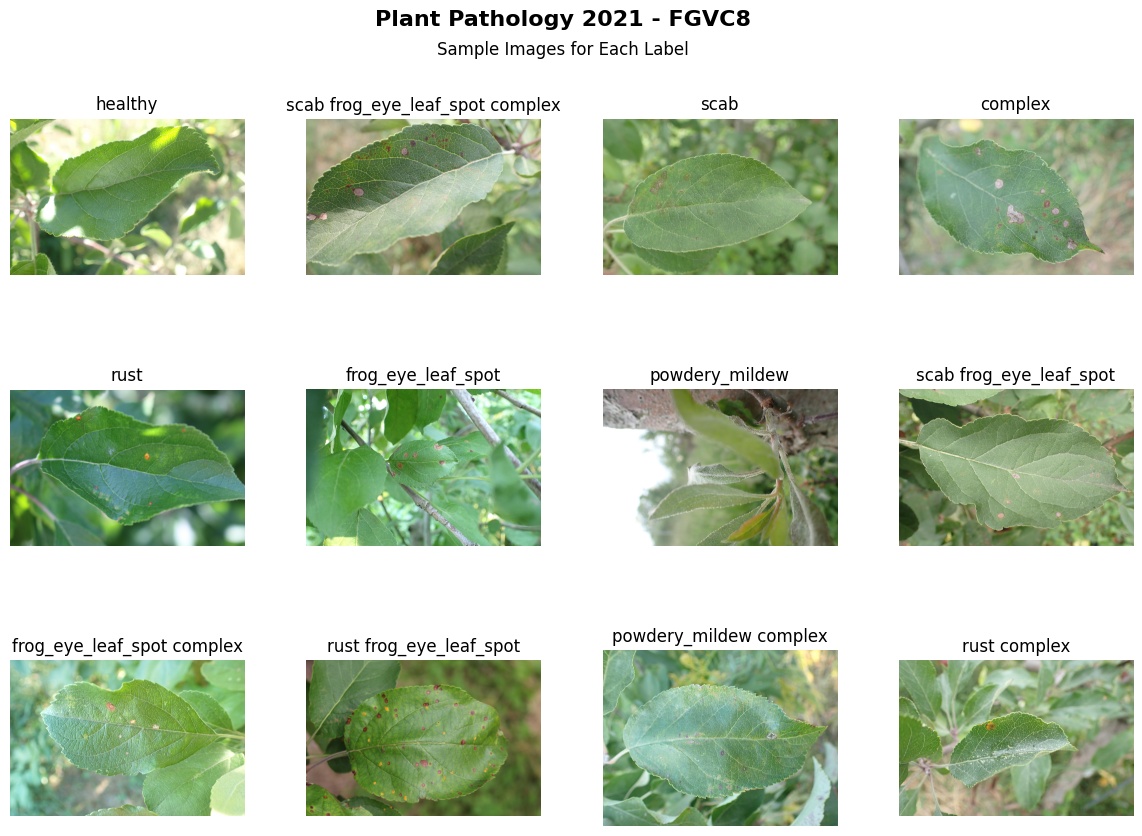

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 4

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
fig.tight_layout()

# Iterate over the labels and plot an image for each label
for i, label in enumerate(labels):
    # Get the first image file for the label
    image_file = os.listdir(os.path.join(train_dir, label))[0]
    image_path = os.path.join(train_dir, label, image_file)

    # Load and plot the image
    img = mpimg.imread(image_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(label)
    axes[row, col].axis('off')

# Remove empty subplots if there are fewer labels than the grid size
if len(labels) < num_rows * num_cols:
    for i in range(len(labels), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

# Set the title and subtitle
title = "Plant Pathology 2021 - FGVC8"
subtitle = "Sample Images for Each Label"

# Add the title and subtitle to the figure
fig.suptitle(title, fontsize=16, fontweight='bold')
fig.subplots_adjust(top=0.9)
fig.text(0.5, 0.93, subtitle, ha='center', fontsize=12)

# Display the plot
plt.show()



# Train the best performing model form RQ1 on the domain related data set to create a domain-adaptive transfer learning model


In [ ]:
from torch.cuda.amp import autocast, GradScaler

from sklearn import metrics
from sklearn.metrics import f1_score

best_optimizer = 'RMSprop'
BATCHSIZE = 32
epochs = 20
best_lr = 0.001


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def define_model():
  model = timm.create_model('convnext_tiny.fb_in1k', pretrained=False, in_chans=3)

  for param in model.parameters():
    param.requires_grad = True

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=12))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.fc.parameters():
    param.requires_grad = True


  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_dir, transform=transform_train)
  test_dataset = ImageFolder(test_dir, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers= 2)

  return train_loader, test_loader


# Generate the model.
model = define_model().to(DEVICE)

# Generate the optimizers.
optimizer_name = best_optimizer
lr = best_lr
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Generate a loss function
criterion = nn.CrossEntropyLoss()

# Get the FashionMNIST dataset.
train_loader, test_loader = get_dataset()

# Initialize GradScaler
scaler = GradScaler()


train_losses = []
train_accuracies = []
train_f1_scores = []
test_losses = []
test_accuracies = []
test_f1_scores = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    y_true_train, y_pred_train = [], []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Compute the train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        y_true_train += labels.cpu().tolist()
        y_pred_train += predicted.cpu().tolist()


    # Compute the train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train
    train_f1_score = metrics.f1_score(y_true_train, y_pred_train, average='macro')

    # Evaluate the model on the validation set
    model.eval()
    correct_valid = 0
    total_valid = 0
    y_true, y_pred = [], []
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    # Compute the validation loss and accuracy
    valid_loss /= len(test_loader)
    valid_accuracy = 100.0 * correct_valid / total_valid

    #calculate the macro f1-score
    test_f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    # Print the results for this epoch
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, , Macro F1 score: {train_f1_score:.4f} - "
          f"Test Loss: {valid_loss:.4f}, Test Accuracy: {valid_accuracy:.2f}%, Macro F1 score: {test_f1_score:.4f}")

    # Append metrics to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1_score)
    test_losses.append(valid_loss)
    test_accuracies.append(valid_accuracy)
    test_f1_scores.append(test_f1_score)

Epoch 1/20 - Train Loss: 1.9116, Train Accuracy: 29.57%, , Macro F1 score: 0.1339 - Test Loss: 1.7697, Test Accuracy: 28.95%, Macro F1 score: 0.1159
Epoch 2/20 - Train Loss: 1.6854, Train Accuracy: 34.16%, , Macro F1 score: 0.1678 - Test Loss: 1.7646, Test Accuracy: 31.20%, Macro F1 score: 0.1208
Epoch 3/20 - Train Loss: 1.6263, Train Accuracy: 37.63%, , Macro F1 score: 0.1914 - Test Loss: 1.5816, Test Accuracy: 42.10%, Macro F1 score: 0.2178
Epoch 4/20 - Train Loss: 1.5717, Train Accuracy: 40.59%, , Macro F1 score: 0.2104 - Test Loss: 1.6186, Test Accuracy: 39.42%, Macro F1 score: 0.1872
Epoch 5/20 - Train Loss: 1.5254, Train Accuracy: 43.42%, , Macro F1 score: 0.2276 - Test Loss: 1.5333, Test Accuracy: 44.11%, Macro F1 score: 0.2391
Epoch 6/20 - Train Loss: 1.4833, Train Accuracy: 45.86%, , Macro F1 score: 0.2426 - Test Loss: 1.4552, Test Accuracy: 48.16%, Macro F1 score: 0.2529
Epoch 7/20 - Train Loss: 1.4325, Train Accuracy: 48.17%, , Macro F1 score: 0.2512 - Test Loss: 1.4367, Tes

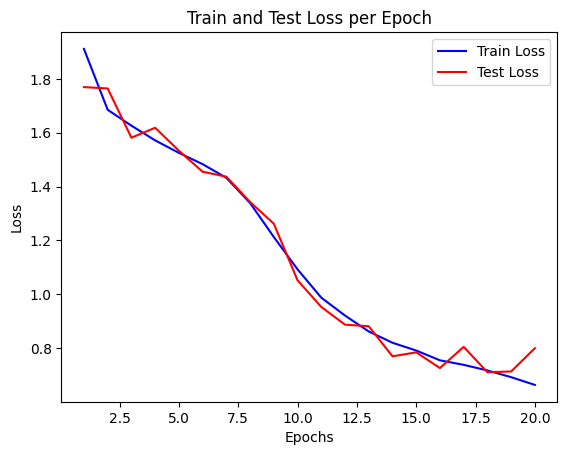

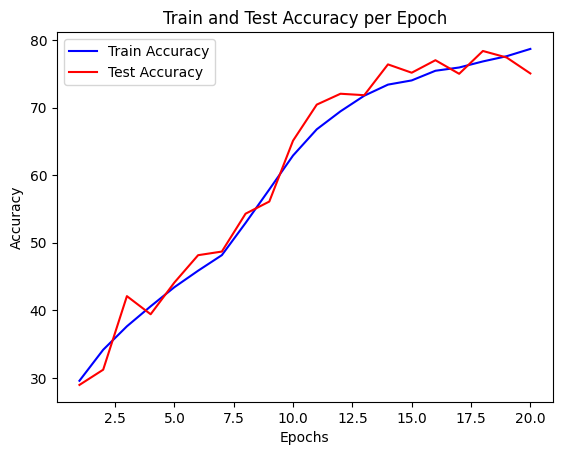

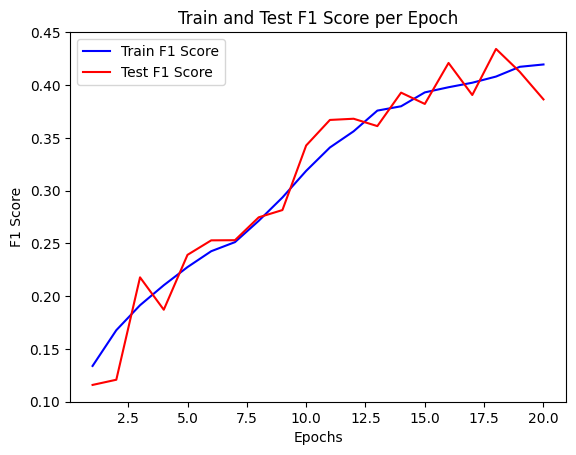

In [ ]:
import matplotlib.pyplot as plt

# Create a list of epochs (assuming you have epoch numbers)
epochs = range(1, len(train_losses) + 1)

# Plot train and test losses
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, test_losses, 'r', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.show()

# Plot train and test accuracies
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy per Epoch')
plt.legend()
plt.show()

# Plot train and test F1 scores
plt.plot(epochs, train_f1_scores, 'b', label='Train F1 Score')
plt.plot(epochs, test_f1_scores, 'r', label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Train and Test F1 Score per Epoch')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the weights of the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Thesis code 2/model_weights_leaves.pth')

# Use created domain adaptation model:

# Prepare dataset, weights and model

## Load in the dataset

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/'
train_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/training/'
val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/test/'

## Calculating pos weight

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train
train_dataset = ImageFolder(train_path)
train_targets = train_dataset.targets
train_class_counts = torch.bincount(torch.tensor(train_targets))

train_total_negative_samples = train_class_counts[0].item()
train_total_positive_samples = train_class_counts[1].item()

train_pos_weight = train_total_negative_samples / train_total_positive_samples

# Put class weight in tensor
train_pos_weight_tensor = torch.tensor(train_pos_weight)
train_pos_weight_tensor = train_pos_weight_tensor.to(DEVICE)
print(train_pos_weight_tensor)

tensor(0.4211, device='cuda:0')


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train_val dataset
train_val_dataset = ImageFolder(train_val_path)
train_val_targets = train_val_dataset.targets
train_val_class_counts = torch.bincount(torch.tensor(train_val_targets))

train_val_total_negative_samples = train_val_class_counts[0].item()
train_val_total_positive_samples = train_val_class_counts[1].item()

train_val_pos_weight = train_val_total_negative_samples / train_val_total_positive_samples

# Put class weight in tensor
train_val_pos_weight_tensor = torch.tensor(train_val_pos_weight)
train_val_pos_weight_tensor = train_val_pos_weight_tensor.to(DEVICE)
print(train_val_pos_weight_tensor)

tensor(0.4204, device='cuda:0')


## load in achitecture previous model to load in weights

In [ ]:
# load in achitecture previous model to load in weights

def define_model():
  model = timm.create_model('convnext_tiny.fb_in1k', pretrained=False, in_chans=3)

  for param in model.parameters():
    param.requires_grad = True

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=12))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.fc.parameters():
    param.requires_grad = True


  return model

# Do hyperparameter tuning Domain adoptation model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100

def tl_model(trial):
  model_achitecture_tf = define_model().to(DEVICE)
  loaded_model = model_achitecture_tf
  loaded_model.load_state_dict(torch.load('/content/model_weights_leaves.pth'))

  for param in loaded_model.parameters():
      param.requires_grad = False

  num_in_features = loaded_model.head.fc[0].in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  loaded_model.head.fc = nn.Sequential(*head)

  for param in loaded_model.head.fc.parameters():
    param.requires_grad = True

  return loaded_model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = tl_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f} %"
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-27 21:46:46,453] A new study created in memory with name: no-name-9324d54a-4e26-4e59-915b-b5334e1a2a90


Epoch [1/100], Train Loss: 0.3559, Train Accuracy: 0.6655% Train specificity: 0.7702, Train sensitivity: 0.6214 Train g_mean: 0.6918% ----> Valid Loss: 0.2719, Valid Accuracy: 0.6962 %Valid specificity: 0.8780, Valid sensitivity: 0.6582 Valid g_mean: 0.7602
Epoch [2/100], Train Loss: 0.3041, Train Accuracy: 0.7348% Train specificity: 0.7782, Train sensitivity: 0.7165 Train g_mean: 0.7467% ----> Valid Loss: 0.2548, Valid Accuracy: 0.7215 %Valid specificity: 0.9268, Valid sensitivity: 0.6786 Valid g_mean: 0.7930
Epoch [3/100], Train Loss: 0.2822, Train Accuracy: 0.7455% Train specificity: 0.8226, Train sensitivity: 0.7131 Train g_mean: 0.7659% ----> Valid Loss: 0.2325, Valid Accuracy: 0.7384 %Valid specificity: 0.8780, Valid sensitivity: 0.7092 Valid g_mean: 0.7891
Epoch [4/100], Train Loss: 0.2877, Train Accuracy: 0.7646% Train specificity: 0.7621, Train sensitivity: 0.7657 Train g_mean: 0.7639% ----> Valid Loss: 0.2358, Valid Accuracy: 0.7300 %Valid specificity: 0.9024, Valid sensitivi

[I 2023-06-27 23:20:05,627] Trial 0 finished with value: 0.8057317071287274 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0006202085765280765, 'weightdecay': 0.006168355234604324, 'use_pos_weight': True}. Best is trial 0 with value: 0.8057317071287274.


Epoch [20/100], Train Loss: 0.2589, Train Accuracy: 0.7826% Train specificity: 0.8306, Train sensitivity: 0.7623 Train g_mean: 0.7957% ----> Valid Loss: 0.2210, Valid Accuracy: 0.7511 %Valid specificity: 0.9024, Valid sensitivity: 0.7194 Valid g_mean: 0.8057
Early stopping criterion met at epoch 19
Epoch [1/100], Train Loss: 0.4897, Train Accuracy: 0.7658% Train specificity: 0.3508, Train sensitivity: 0.9406 Train g_mean: 0.5744% ----> Valid Loss: 0.3465, Valid Accuracy: 0.8523 %Valid specificity: 0.7317, Valid sensitivity: 0.8776 Valid g_mean: 0.8013
Epoch [2/100], Train Loss: 0.4324, Train Accuracy: 0.7993% Train specificity: 0.5484, Train sensitivity: 0.9049 Train g_mean: 0.7044% ----> Valid Loss: 0.3529, Valid Accuracy: 0.8608 %Valid specificity: 0.8293, Valid sensitivity: 0.8673 Valid g_mean: 0.8481
Epoch [3/100], Train Loss: 0.4092, Train Accuracy: 0.7969% Train specificity: 0.5524, Train sensitivity: 0.8998 Train g_mean: 0.7050% ----> Valid Loss: 0.3017, Valid Accuracy: 0.8819 %

[I 2023-06-28 00:11:24,221] Trial 1 finished with value: 0.8653785529008714 and parameters: {'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.0009821819502478753, 'weightdecay': 0.001174159063886338, 'use_pos_weight': False}. Best is trial 1 with value: 0.8653785529008714.


Epoch [11/100], Train Loss: 0.3627, Train Accuracy: 0.8387% Train specificity: 0.6532, Train sensitivity: 0.9168 Train g_mean: 0.7739% ----> Valid Loss: 0.3055, Valid Accuracy: 0.8903 %Valid specificity: 0.8293, Valid sensitivity: 0.9031 Valid g_mean: 0.8654
Early stopping criterion met at epoch 10
Epoch [1/100], Train Loss: 0.4726, Train Accuracy: 0.7706% Train specificity: 0.4395, Train sensitivity: 0.9100 Train g_mean: 0.6324% ----> Valid Loss: 0.3868, Valid Accuracy: 0.8523 %Valid specificity: 0.7561, Valid sensitivity: 0.8724 Valid g_mean: 0.8122
Epoch [2/100], Train Loss: 0.4249, Train Accuracy: 0.7933% Train specificity: 0.5444, Train sensitivity: 0.8981 Train g_mean: 0.6992% ----> Valid Loss: 0.2861, Valid Accuracy: 0.8819 %Valid specificity: 0.5366, Valid sensitivity: 0.9541 Valid g_mean: 0.7155
Epoch [3/100], Train Loss: 0.4324, Train Accuracy: 0.7838% Train specificity: 0.4718, Train sensitivity: 0.9151 Train g_mean: 0.6571% ----> Valid Loss: 0.3645, Valid Accuracy: 0.8270 %

[I 2023-06-28 01:02:46,523] Trial 2 finished with value: 0.8395405128834008 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.005058415226597097, 'weightdecay': 0.001426289703038213, 'use_pos_weight': False}. Best is trial 1 with value: 0.8653785529008714.


Epoch [11/100], Train Loss: 0.3926, Train Accuracy: 0.8112% Train specificity: 0.5726, Train sensitivity: 0.9117 Train g_mean: 0.7225% ----> Valid Loss: 0.3200, Valid Accuracy: 0.8819 %Valid specificity: 0.7805, Valid sensitivity: 0.9031 Valid g_mean: 0.8395
Early stopping criterion met at epoch 10
Epoch [1/100], Train Loss: 0.4711, Train Accuracy: 0.7730% Train specificity: 0.4637, Train sensitivity: 0.9032 Train g_mean: 0.6472% ----> Valid Loss: 0.3114, Valid Accuracy: 0.8861 %Valid specificity: 0.6098, Valid sensitivity: 0.9439 Valid g_mean: 0.7586
Epoch [2/100], Train Loss: 0.4259, Train Accuracy: 0.7957% Train specificity: 0.5282, Train sensitivity: 0.9083 Train g_mean: 0.6927% ----> Valid Loss: 0.5402, Valid Accuracy: 0.6920 %Valid specificity: 0.9268, Valid sensitivity: 0.6429 Valid g_mean: 0.7719
Epoch [3/100], Train Loss: 0.4171, Train Accuracy: 0.7969% Train specificity: 0.5847, Train sensitivity: 0.8862 Train g_mean: 0.7198% ----> Valid Loss: 0.2911, Valid Accuracy: 0.8903 %

[I 2023-06-28 01:49:24,802] Trial 3 finished with value: 0.7776750585974579 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.00048729648225131664, 'weightdecay': 0.0017067898155498408, 'use_pos_weight': False}. Best is trial 1 with value: 0.8653785529008714.


Epoch [10/100], Train Loss: 0.4058, Train Accuracy: 0.7981% Train specificity: 0.5484, Train sensitivity: 0.9032 Train g_mean: 0.7038% ----> Valid Loss: 0.2989, Valid Accuracy: 0.8734 %Valid specificity: 0.6585, Valid sensitivity: 0.9184 Valid g_mean: 0.7777
Early stopping criterion met at epoch 9
Epoch [1/100], Train Loss: 0.3335, Train Accuracy: 0.7109% Train specificity: 0.7056, Train sensitivity: 0.7131 Train g_mean: 0.7093% ----> Valid Loss: 0.3095, Valid Accuracy: 0.6203 %Valid specificity: 0.9512, Valid sensitivity: 0.5510 Valid g_mean: 0.7240
Epoch [2/100], Train Loss: 0.3010, Train Accuracy: 0.7348% Train specificity: 0.7702, Train sensitivity: 0.7199 Train g_mean: 0.7446% ----> Valid Loss: 0.2672, Valid Accuracy: 0.6667 %Valid specificity: 0.9512, Valid sensitivity: 0.6071 Valid g_mean: 0.7600
Epoch [3/100], Train Loss: 0.2675, Train Accuracy: 0.7802% Train specificity: 0.8427, Train sensitivity: 0.7538 Train g_mean: 0.7970% ----> Valid Loss: 0.1829, Valid Accuracy: 0.8776 %V

[I 2023-06-28 02:26:45,300] Trial 4 finished with value: 0.6912667187532958 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0020599399933177442, 'weightdecay': 0.002291657337212525, 'use_pos_weight': True}. Best is trial 1 with value: 0.8653785529008714.


Epoch [8/100], Train Loss: 0.2623, Train Accuracy: 0.7802% Train specificity: 0.7984, Train sensitivity: 0.7725 Train g_mean: 0.7853% ----> Valid Loss: 0.3621, Valid Accuracy: 0.5738 %Valid specificity: 0.9756, Valid sensitivity: 0.4898 Valid g_mean: 0.6913
Early stopping criterion met at epoch 7
Epoch [1/100], Train Loss: 0.3870, Train Accuracy: 0.5054% Train specificity: 0.8911, Train sensitivity: 0.3430 Train g_mean: 0.5528% ----> Valid Loss: 0.3218, Valid Accuracy: 0.6456 %Valid specificity: 0.9268, Valid sensitivity: 0.5867 Valid g_mean: 0.7374


[I 2023-06-28 02:36:06,254] Trial 5 pruned. 


Epoch [2/100], Train Loss: 0.3420, Train Accuracy: 0.6953% Train specificity: 0.8226, Train sensitivity: 0.6418 Train g_mean: 0.7266% ----> Valid Loss: 0.2830, Valid Accuracy: 0.7215 %Valid specificity: 0.8780, Valid sensitivity: 0.6888 Valid g_mean: 0.7777
Epoch [1/100], Train Loss: 0.4011, Train Accuracy: 0.6332% Train specificity: 0.5202, Train sensitivity: 0.6808 Train g_mean: 0.5951% ----> Valid Loss: 0.3410, Valid Accuracy: 0.6329 %Valid specificity: 0.9024, Valid sensitivity: 0.5765 Valid g_mean: 0.7213


[I 2023-06-28 02:44:59,261] Trial 6 pruned. 


Epoch [2/100], Train Loss: 0.3756, Train Accuracy: 0.6440% Train specificity: 0.8508, Train sensitivity: 0.5569 Train g_mean: 0.6883% ----> Valid Loss: 0.3242, Valid Accuracy: 0.6582 %Valid specificity: 0.9024, Valid sensitivity: 0.6071 Valid g_mean: 0.7402
Epoch [1/100], Train Loss: 0.3766, Train Accuracy: 0.6894% Train specificity: 0.6532, Train sensitivity: 0.7046 Train g_mean: 0.6784% ----> Valid Loss: 0.3024, Valid Accuracy: 0.6920 %Valid specificity: 0.9024, Valid sensitivity: 0.6480 Valid g_mean: 0.7647
Epoch [2/100], Train Loss: 0.3224, Train Accuracy: 0.7611% Train specificity: 0.7661, Train sensitivity: 0.7589 Train g_mean: 0.7625% ----> Valid Loss: 0.2625, Valid Accuracy: 0.7300 %Valid specificity: 0.8780, Valid sensitivity: 0.6990 Valid g_mean: 0.7834
Epoch [3/100], Train Loss: 0.3033, Train Accuracy: 0.7539% Train specificity: 0.8065, Train sensitivity: 0.7317 Train g_mean: 0.7682% ----> Valid Loss: 0.2466, Valid Accuracy: 0.7553 %Valid specificity: 0.9024, Valid sensitivi

[I 2023-06-28 03:15:53,218] Trial 7 pruned. 


Epoch [7/100], Train Loss: 0.2754, Train Accuracy: 0.7682% Train specificity: 0.7984, Train sensitivity: 0.7555 Train g_mean: 0.7767% ----> Valid Loss: 0.2321, Valid Accuracy: 0.7468 %Valid specificity: 0.9024, Valid sensitivity: 0.7143 Valid g_mean: 0.8029
Epoch [1/100], Train Loss: 0.3624, Train Accuracy: 0.6547% Train specificity: 0.8024, Train sensitivity: 0.5925 Train g_mean: 0.6895% ----> Valid Loss: 0.2840, Valid Accuracy: 0.6962 %Valid specificity: 0.9024, Valid sensitivity: 0.6531 Valid g_mean: 0.7677
Epoch [2/100], Train Loss: 0.3069, Train Accuracy: 0.7587% Train specificity: 0.7782, Train sensitivity: 0.7504 Train g_mean: 0.7642% ----> Valid Loss: 0.2448, Valid Accuracy: 0.7468 %Valid specificity: 0.9024, Valid sensitivity: 0.7143 Valid g_mean: 0.8029
Epoch [3/100], Train Loss: 0.2841, Train Accuracy: 0.7563% Train specificity: 0.8427, Train sensitivity: 0.7199 Train g_mean: 0.7789% ----> Valid Loss: 0.2642, Valid Accuracy: 0.6878 %Valid specificity: 0.9512, Valid sensitivi

[I 2023-06-28 03:33:05,646] Trial 8 pruned. 


Epoch [4/100], Train Loss: 0.2717, Train Accuracy: 0.7849% Train specificity: 0.8508, Train sensitivity: 0.7572 Train g_mean: 0.8026% ----> Valid Loss: 0.2377, Valid Accuracy: 0.7342 %Valid specificity: 0.9024, Valid sensitivity: 0.6990 Valid g_mean: 0.7942
Epoch [1/100], Train Loss: 0.2958, Train Accuracy: 0.7479% Train specificity: 0.7823, Train sensitivity: 0.7334 Train g_mean: 0.7575% ----> Valid Loss: 0.2505, Valid Accuracy: 0.7046 %Valid specificity: 0.9268, Valid sensitivity: 0.6582 Valid g_mean: 0.7810
Epoch [2/100], Train Loss: 0.2661, Train Accuracy: 0.7646% Train specificity: 0.8266, Train sensitivity: 0.7385 Train g_mean: 0.7813% ----> Valid Loss: 0.1955, Valid Accuracy: 0.8650 %Valid specificity: 0.8049, Valid sensitivity: 0.8776 Valid g_mean: 0.8404
Epoch [3/100], Train Loss: 0.2589, Train Accuracy: 0.7861% Train specificity: 0.8226, Train sensitivity: 0.7708 Train g_mean: 0.7963% ----> Valid Loss: 0.2382, Valid Accuracy: 0.7089 %Valid specificity: 0.9268, Valid sensitivi

[I 2023-06-28 04:02:33,370] Trial 9 finished with value: 0.7854766824774488 and parameters: {'first_neuron': 128, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.008292912478918679, 'weightdecay': 0.005065642917127714, 'use_pos_weight': True}. Best is trial 1 with value: 0.8653785529008714.


In [ ]:
trials_df = study.trials_dataframe()
trials_df

NameError: ignored

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

# Train the Domain adoptation model with the best hyperparameters (on combined training and validation dataset

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 512
best_dropout = 0.3
best_optimizer = 'AdamW'
best_lr = 0.0009821819502478753
epochs = 11
weight_decay = 0.001174159063886338
use_pos_weight = False



def tl_model():
  model_achitecture_tf = define_model().to(DEVICE)
  loaded_model = model_achitecture_tf
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis code 2/model_weights_leaves.pth'))

  for param in loaded_model.parameters():
      param.requires_grad = False

  num_in_features = loaded_model.head.fc[0].in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  loaded_model.head.fc = nn.Sequential(*head)

  for param in loaded_model.head.fc.parameters():
    param.requires_grad = True

  return loaded_model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = tl_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/11], Train_val Loss: 0.4800, Train_val Accuracy: 0.7363%, Train_val specificity: 0.3697, Train_val sensitivity: 0.8904, Train_val g_mean: 0.5738% ----> Test Loss: 0.3090, Test Accuracy: 0.8958%, Test specificity: 0.6667, Test sensitivity: 0.9444, Test g_mean: 0.7935
Epoch [2/11], Train_val Loss: 0.3977, Train_val Accuracy: 0.8063%, Train_val specificity: 0.5909, Train_val sensitivity: 0.8968, Train_val g_mean: 0.7280% ----> Test Loss: 0.3030, Test Accuracy: 0.8875%, Test specificity: 0.6190, Test sensitivity: 0.9444, Test g_mean: 0.7646
Epoch [3/11], Train_val Loss: 0.3834, Train_val Accuracy: 0.8081%, Train_val specificity: 0.6091, Train_val sensitivity: 0.8917, Train_val g_mean: 0.7370% ----> Test Loss: 0.2891, Test Accuracy: 0.9042%, Test specificity: 0.7143, Test sensitivity: 0.9444, Test g_mean: 0.8213
Epoch [4/11], Train_val Loss: 0.3567, Train_val Accuracy: 0.8368%, Train_val specificity: 0.6485, Train_val sensitivity: 0.9159, Train_val g_mean: 0.7707% ----> Test Loss: 

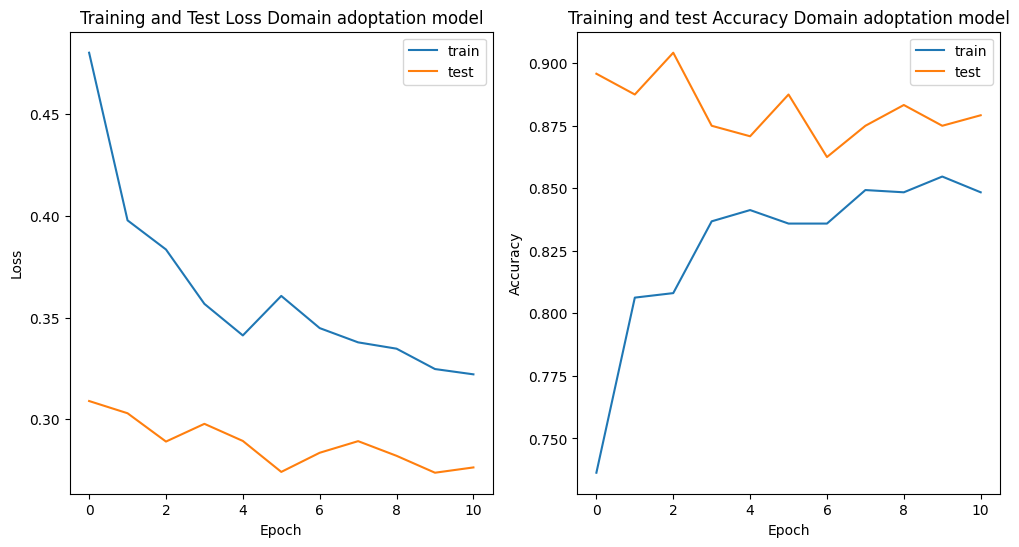

In [ ]:
# Plot the validation and training loss and accuracy values

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss Domain adoptation model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy Domain adoptation model')
ax[1].legend()
plt.show()

# Test model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.2763824641704559
Accuracy: 0.8791666666666667

Specificity: 0.6190476190476191
Sensitivity: 0.9343434343434344
g_mean: 0.7605281575346691

Precision: 0.9203980099502488
Recall: 0.9343434343434344
F1-score: 0.9273182957393483
F1_score_macro: 0.7846468021906619
AUC-ROC: 0.9125781625781625

              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64        42
         1.0       0.92      0.93      0.93       198

    accuracy                           0.88       240
   macro avg       0.79      0.78      0.78       240
weighted avg       0.88      0.88      0.88       240



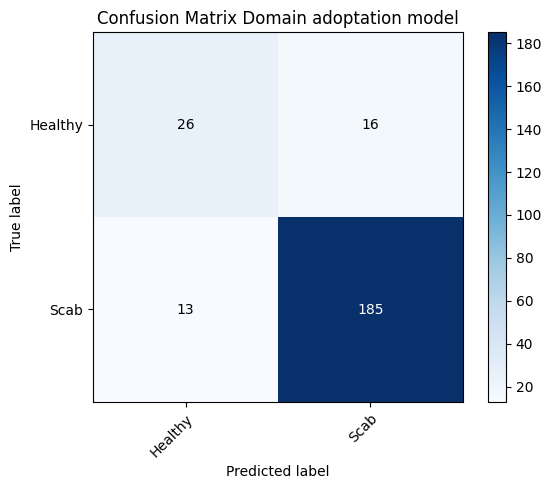

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Domain adoptation model")
plt.show()